# Autoencoder
### Load Data and Augment

In [40]:
ComputeLB = False

import os, gc, zipfile
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

if ComputeLB: PATH = 'simdata/image/'
else: PATH = 'simdata/image/'
IMAGES = os.listdir(PATH)
print('There are',len(IMAGES),'images. Here are 5 example filesnames:')
print(IMAGES[:5])

There are 1000 images. Here are 5 example filesnames:
['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '101.jpg']


### Build Autoencoder

In [41]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [42]:
BATCH_SIZE = 100; EPOCHS = 50
train_datagen = ImageDataGenerator(rescale=1./255)
train_batches = train_datagen.flow_from_directory('simdata/',
        target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)

Found 1000 images belonging to 1 classes.


In [43]:
#ENCODER
input_img = Input(shape=(64, 64, 3))  
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# LATENT SPACE
latentSize = (8,8,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))

autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

### Train Autoencoder

In [44]:
history = autoencoder.fit_generator(train_batches,
        steps_per_epoch = train_batches.samples // BATCH_SIZE,
        epochs = EPOCHS, verbose=2)

Epoch 1/50
10/10 - 42s - loss: 0.6579
Epoch 2/50
10/10 - 42s - loss: 0.6139
Epoch 3/50
10/10 - 45s - loss: 0.5940
Epoch 4/50
10/10 - 54s - loss: 0.5736
Epoch 5/50
10/10 - 40s - loss: 0.5603
Epoch 6/50
10/10 - 46s - loss: 0.5540
Epoch 7/50
10/10 - 44s - loss: 0.5489
Epoch 8/50
10/10 - 45s - loss: 0.5489
Epoch 9/50
10/10 - 34s - loss: 0.5427
Epoch 10/50
10/10 - 41s - loss: 0.5388
Epoch 11/50
10/10 - 38s - loss: 0.5360
Epoch 12/50
10/10 - 38s - loss: 0.5333
Epoch 13/50
10/10 - 37s - loss: 0.5322
Epoch 14/50
10/10 - 37s - loss: 0.5295
Epoch 15/50
10/10 - 38s - loss: 0.5314
Epoch 16/50
10/10 - 42s - loss: 0.5314
Epoch 17/50
10/10 - 43s - loss: 0.5281
Epoch 18/50
10/10 - 38s - loss: 0.5260
Epoch 19/50
10/10 - 45s - loss: 0.5271
Epoch 20/50
10/10 - 42s - loss: 0.5254
Epoch 21/50
10/10 - 40s - loss: 0.5238
Epoch 22/50
10/10 - 42s - loss: 0.5257
Epoch 23/50
10/10 - 39s - loss: 0.5248
Epoch 24/50
10/10 - 40s - loss: 0.5226
Epoch 25/50
10/10 - 38s - loss: 0.5217
Epoch 26/50
10/10 - 35s - loss: 0.

### View Reconstruction

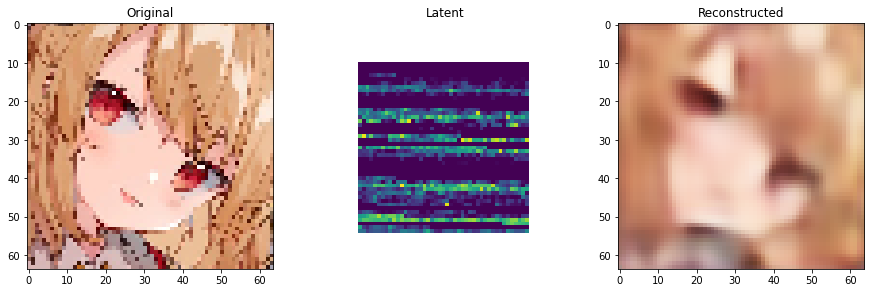

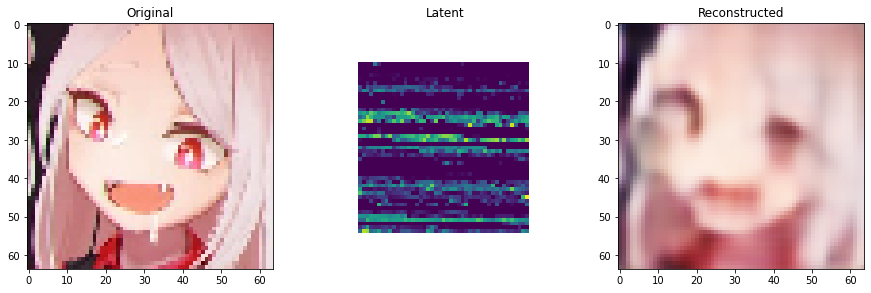

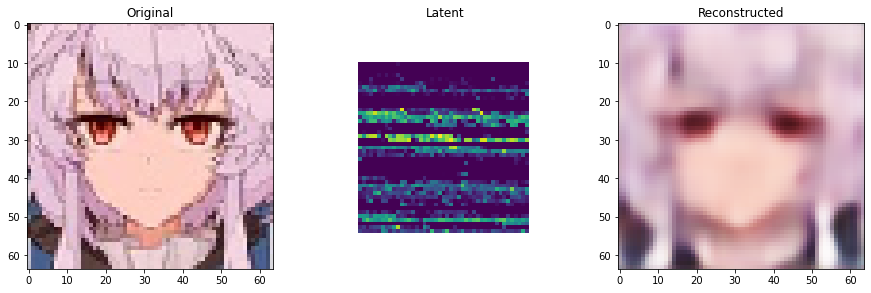

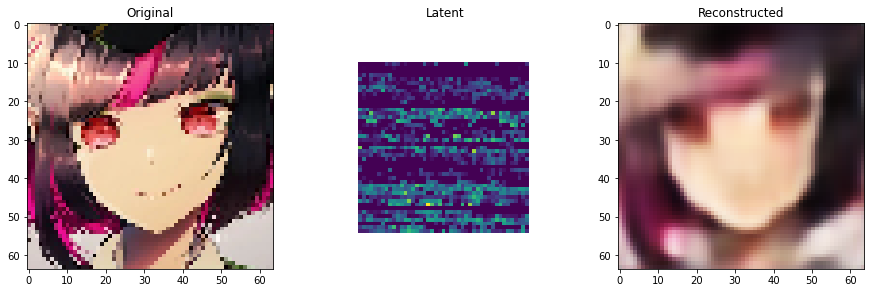

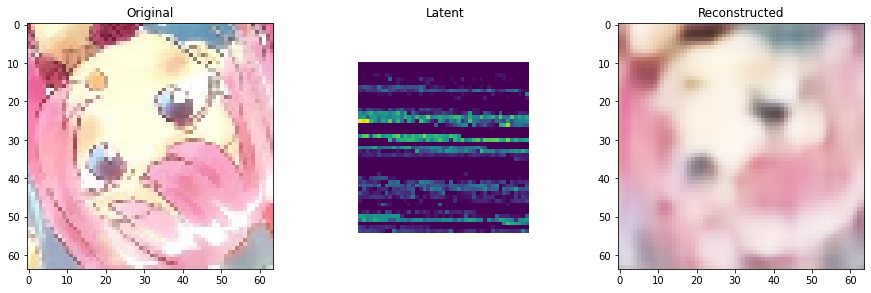

In [45]:
images = next(iter(train_batches))[0]
for i in range(5):

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    
    # ORIGINAL IMAGE
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    plt.title('Original')
    plt.imshow(img)

    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    img = Image.fromarray( latent_flat[:2025].astype('uint8').reshape((45,45)), mode='L') 
    plt.subplot(1,3,2)
    plt.title('Latent')
    plt.xlim((-10,55))
    plt.ylim((-10,55))
    plt.axis('off')
    plt.imshow(img)

    # RECONSTRUCTED IMAGE
    decoded_imgs = decoder.predict(latent_img[0].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.subplot(1,3,3)
    plt.title('Reconstructed')
    plt.imshow(img)
    
    plt.show()

### Latent Space and Generation

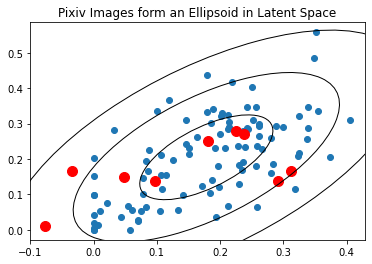

In [46]:
from matplotlib.patches import Ellipse

# PROJECT LATENT INTO 2D, AVOID DEAD RELU
latent_img = encoder.predict(images)
latent_img2 = latent_img.reshape((-1,latentSize[0]*latentSize[1]*latentSize[2]))
d = 0; s = 0
while s<0.1:
    x = latent_img2[:,d]
    s = np.std(x); d += 1
s = 0
while s<0.1:
    y = latent_img2[:,d]
    s = np.std(y); d += 1

# CALCULATE ELLIPSOID FROM 256 IMAGES
cov = np.cov(x, y)
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)
for j in [1,2,3]:
    ell = Ellipse(xy=(np.mean(x), np.mean(y)), width=lambda_[0]*j*2, 
            height=lambda_[1]*j*2, angle=np.rad2deg(np.arccos(v[0, 0])))
    ell.set_facecolor('None')
    ell.set_edgecolor('black')
    plt.gca().add_artist(ell)
    
# PLOT 256 IMAGES AS DOTS IN LATENT SPACE
plt.scatter(x,y)
d = np.random.multivariate_normal([np.mean(x),np.mean(y)],cov,9)
plt.scatter(d[:,0],d[:,1],color='red',s=100)
plt.title('Pixiv Images form an Ellipsoid in Latent Space')
plt.show()

In [47]:
 # CREATE 100 CROPPED IMAGES
# x = np.random.choice(np.arange(500),100)
# images = np.zeros((100,64,64,3))
# for i in range(len(x)):
#     img = Image.open(PATH + IMAGES[x[i]])
#     img = img.resize((100,int(img.size[1]/(img.size[0]/100))), Image.ANTIALIAS)
#     img = img.crop((18, 0, 82, 64))
#     images[i,:,:,:] = np.asarray(img).astype('float32') / 255.
    
    
encoded_imgs = encoder.predict(images)
sz = latentSize[0] * latentSize[1] * latentSize[2]
encoded_imgs = encoded_imgs.reshape((-1,sz))
mm = np.mean(encoded_imgs,axis=0)
ss = np.cov(encoded_imgs,rowvar=False)
# GENERATE 9 RANDOM DOG IMAGES
generated = np.random.multivariate_normal(mm,ss,9)
generated = generated.reshape((-1,latentSize[0],latentSize[1],latentSize[2]))



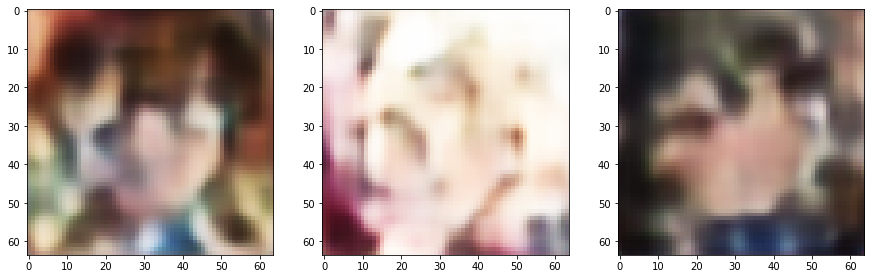

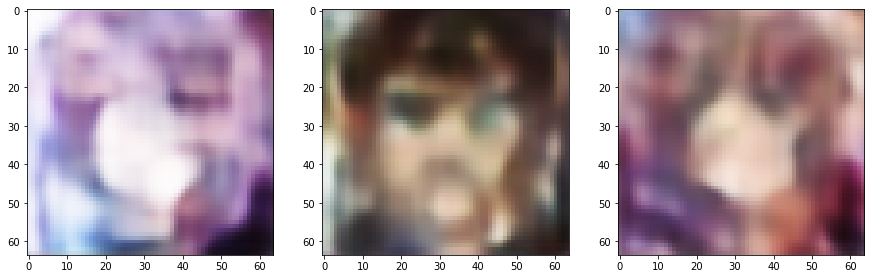

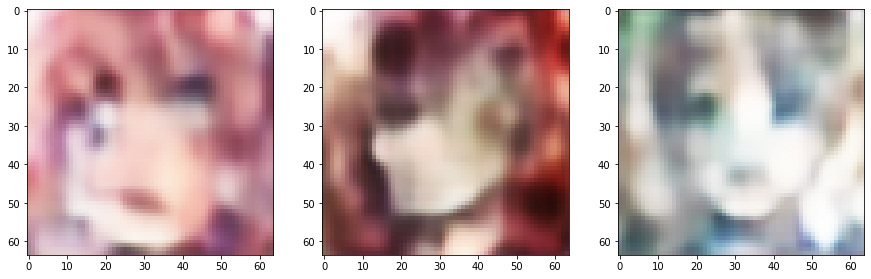

In [48]:
# PLOT 9 RANDOM IMAGES
for k in range(3):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    decoded_imgs = decoder.predict(generated[k*3].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,3,2)
    decoded_imgs = decoder.predict(generated[k*3+1].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,3,3)
    decoded_imgs = decoder.predict(generated[k*3+2].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.show()


### Generating Better Images

In [49]:
# DISTANCE TO MOVE AWAY FROM EXISTING TRAIN IMAGES
beta = 0.35
# GENERATE 9 RANDOM DOG IMAGES
generated = np.random.multivariate_normal(mm,ss,9)
generated = beta*generated + (1-beta)*encoded_imgs[:9]

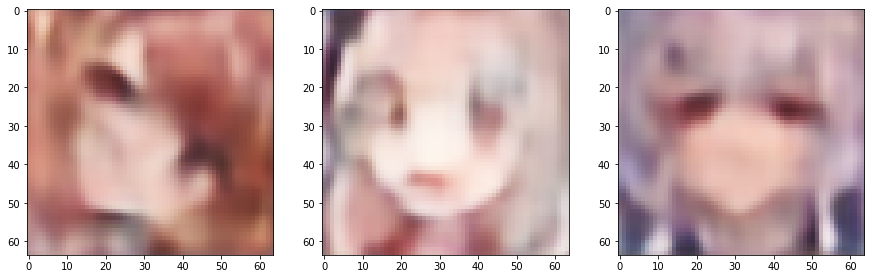

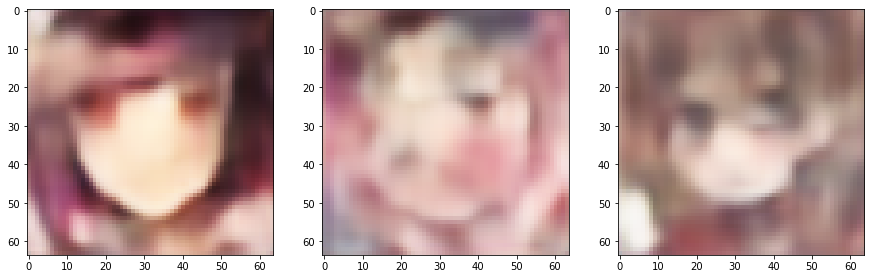

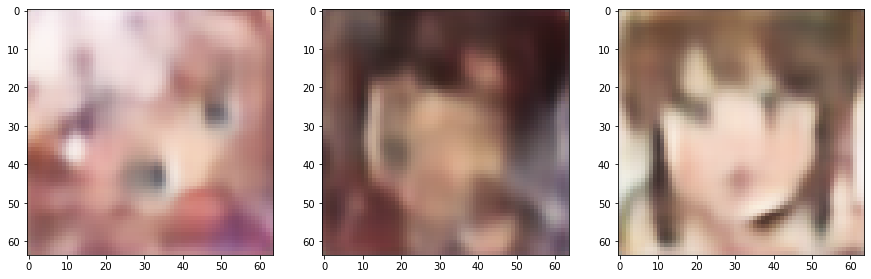

In [50]:
for k in range(3):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    decoded_imgs = decoder.predict(generated[k*3].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,3,2)
    decoded_imgs = decoder.predict(generated[k*3+1].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.subplot(1,3,3)
    decoded_imgs = decoder.predict(generated[k*3+2].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.imshow(img)
    plt.show()

Copyright <2021>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so,subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.